# Bayesian Optimisation of starting Gaussian Process hyperparameters

In [1]:
from pathlib import Path
from shutil import copyfile
import pickle

Data manipulation

In [2]:
import numpy as np
import pandas as pd

Plotting / Visualisation

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 6)

Gaussian Process Regression

In [5]:
import gpflow
import tensorflow as tf

In [6]:
tf.config.list_physical_devices('GPU')

[]

In [7]:
from gpflow.utilities import print_summary

In [8]:
gpflow.config.set_default_summary_fmt("notebook")

Input scaler:

In [9]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.exceptions import NotFittedError

Bayesian optimisation based on gaussian processes:

In [10]:
import trieste

## Load previously exported data

In [11]:
#dict_cols = pickle.load(open(Path("dict_cols.pkl"), 'rb'))
dfs_train = pickle.load(open(Path("dfs_train.pkl"), 'rb'))
dfs_test = pickle.load(open(Path("dfs_test.pkl"), 'rb'))

In [12]:
train_exps = ['Exp1', 'Exp3', 'Exp5', 'Exp6']
test_exps = ['Exp2', 'Exp4', 'Exp7']

In [13]:
t_cols = ['time_h', 'time_m']
w_cols = ['SolRad', 'OutsideTemp']
u_cols = ['SimulatedHeat']
y_cols = ['SimulatedTemp']

In [14]:
t_lags = 3
w_lags = 1
u_lags = 1
y_lags = 3

In [15]:
dict_cols = {
    't': (t_lags, t_cols),
    'w': (w_lags, w_cols),
    'u': (u_lags, u_cols),
    'y': (y_lags, y_cols)
}

Create the scaler and set up input data scaling:

In [16]:
scaler = MinMaxScaler()

In [17]:
def get_scaled_df(df, dict_cols, scaler):
    
    t_list = dict_cols['t'][1]
    w_list = dict_cols['w'][1]
    u_list = dict_cols['u'][1]
    y_list = dict_cols['y'][1]
    
    df_local = df[t_list + w_list + u_list + y_list]
    df_scaled = df_local.to_numpy()
    
    try:
        df_scaled = scaler.transform(df_scaled)
    except NotFittedError:
        df_scaled = scaler.fit_transform(df_scaled)
        
    df_scaled = pd.DataFrame(df_scaled, index = df_local.index, columns = df_local.columns)
    
    return df_scaled

In [18]:
df_train = pd.concat(dfs_train)

Condition number of the raw input data:

In [19]:
np.linalg.cond(df_train.to_numpy())

35185.23586737608

Fit the scaler and scale the data:

In [20]:
df_train_sc = get_scaled_df(df_train, dict_cols, scaler)

Check the condition number of the input data:

In [21]:
np.linalg.cond(df_train_sc.to_numpy())

17.921225042813802

NOTE: Condition number of scaled data is much smaller. This makes sense.

Scale the data for each experiment individually. Used for validation graphs:

In [22]:
dfs_train_sc = []
dfs_test_sc = []
for df in dfs_train:
    df_sc = get_scaled_df(df, dict_cols, scaler)
    dfs_train_sc.append(df_sc)
    
for df in dfs_test:
    df_sc = get_scaled_df(df, dict_cols, scaler)
    dfs_test_sc.append(df_sc)

Set up the function which generated the GPR input matrix from the experimental data (including all autoregressive inputs, etc.):

In [23]:
def data_to_gpr(df, dict_cols):
    
    t_list = dict_cols['t'][1]
    w_list = dict_cols['w'][1]
    u_list = dict_cols['u'][1]
    y_list = dict_cols['y'][1]
    
    df_gpr = df[t_list + w_list + u_list + y_list].copy()
    
    for lags, names in dict_cols.values():
        for name in names:
            col_idx = df_gpr.columns.get_loc(name)
            for lag in range(1, lags + 1):
                df_gpr.insert(col_idx + lag, f"{name}_{lag}", df_gpr.loc[:, name].shift(lag))

    df_gpr.dropna(inplace = True)
    
    return df_gpr

In [24]:
dfs_gpr_train = []
for df_sc in dfs_train_sc:
    dfs_gpr_train.append(data_to_gpr(df_sc, dict_cols))
df_gpr_train = pd.concat(dfs_gpr_train)
df_gpr_train.head()

,time_h,time_h_1,time_h_2,time_h_3,time_m,time_m_1,time_m_2,time_m_3,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat,SimulatedHeat_1,SimulatedTemp,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
timestamp,,,,,,,,,,,,,,,,,,
2017-06-01 20:15:00+02:00,0.869565,0.869565,0.869565,0.869565,0.272727,0.181818,0.090909,0.000000,0.070193,0.052175,0.529412,0.529412,0.209943,0.209943,0.433660,0.452997,0.461555,0.500451
2017-06-01 20:20:00+02:00,0.869565,0.869565,0.869565,0.869565,0.363636,0.272727,0.181818,0.090909,0.072266,0.070193,0.529412,0.529412,0.047930,0.209943,0.410220,0.433660,0.452997,0.461555
2017-06-01 20:25:00+02:00,0.869565,0.869565,0.869565,0.869565,0.454545,0.363636,0.272727,0.181818,0.061755,0.072266,0.529412,0.529412,0.047930,0.047930,0.395873,0.410220,0.433660,0.452997
2017-06-01 20:30:00+02:00,0.869565,0.869565,0.869565,0.869565,0.545455,0.454545,0.363636,0.272727,0.044350,0.061755,0.529412,0.529412,0.047930,0.047930,0.388866,0.395873,0.410220,0.433660
2017-06-01 20:35:00+02:00,0.869565,0.869565,0.869565,0.869565,0.636364,0.545455,0.454545,0.363636,0.033265,0.044350,0.529412,0.529412,0.047930,0.047930,0.382572,0.388866,0.395873,0.410220


In [25]:
dfs_gpr_test = []
for df_sc in dfs_test_sc:
    dfs_gpr_test.append(data_to_gpr(df_sc, dict_cols))

In [26]:
#df_gpr_train = df_gpr_train.sample(n = 250)

In [27]:
df_input_train = df_gpr_train.drop(columns = dict_cols['u'][1] + dict_cols['y'][1])
df_output_train = df_gpr_train[dict_cols['y'][1]]

np_input_train = df_input_train.to_numpy()
np_output_train = df_output_train.to_numpy().reshape(-1, 1)

In [28]:
df_input_train.head()

,time_h,time_h_1,time_h_2,time_h_3,time_m,time_m_1,time_m_2,time_m_3,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat_1,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
timestamp,,,,,,,,,,,,,,,,
2017-06-01 20:15:00+02:00,0.869565,0.869565,0.869565,0.869565,0.272727,0.181818,0.090909,0.000000,0.070193,0.052175,0.529412,0.529412,0.209943,0.452997,0.461555,0.500451
2017-06-01 20:20:00+02:00,0.869565,0.869565,0.869565,0.869565,0.363636,0.272727,0.181818,0.090909,0.072266,0.070193,0.529412,0.529412,0.209943,0.433660,0.452997,0.461555
2017-06-01 20:25:00+02:00,0.869565,0.869565,0.869565,0.869565,0.454545,0.363636,0.272727,0.181818,0.061755,0.072266,0.529412,0.529412,0.047930,0.410220,0.433660,0.452997
2017-06-01 20:30:00+02:00,0.869565,0.869565,0.869565,0.869565,0.545455,0.454545,0.363636,0.272727,0.044350,0.061755,0.529412,0.529412,0.047930,0.395873,0.410220,0.433660
2017-06-01 20:35:00+02:00,0.869565,0.869565,0.869565,0.869565,0.636364,0.545455,0.454545,0.363636,0.033265,0.044350,0.529412,0.529412,0.047930,0.388866,0.395873,0.410220


In [29]:
## Define Kernel

In [30]:
nb_dims = np_input_train.shape[1]
rational_dims = np.arange(0, (dict_cols['t'][0] + 1) * len(dict_cols['t'][1]), 1)
nb_rational_dims = len(rational_dims)
squared_dims = np.arange(nb_rational_dims, nb_dims, 1)
nb_squared_dims = len(squared_dims)

In [31]:
print(f"rational: {nb_rational_dims}")
print(f"squared: {nb_squared_dims}")

rational: 8
squared: 8


In [32]:
squared_l = np.linspace(0.1, 1, nb_squared_dims)
rational_l = np.linspace(0.1, 1, nb_rational_dims)

In [33]:
variance = tf.math.reduce_variance(np_input_train)

In [34]:
k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
k1 = gpflow.kernels.Constant(variance = variance)
k2 = gpflow.kernels.RationalQuadratic(lengthscales = rational_l, active_dims = rational_dims, variance = variance)
k3 = gpflow.kernels.Periodic(k2)

In [35]:
k = (k0 + k1) * k2
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,0.08675270018153766
Product.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[0.1, 0.22857143, 0.35714286..."
Product.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,0.08675270018153766
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.08675270018153766
Product.kernels[1].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[0.1, 0.22857143, 0.35714286..."
Product.kernels[1].alpha,Parameter,Softplus,,True,(),float64,1.0


## Compile Model

In [36]:
m = gpflow.models.GPR(
    data = (np_input_train, np_output_train), 
    kernel = k, 
    mean_function = None
    )
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,0.08675270018153766
GPR.kernel.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[0.1, 0.22857143, 0.35714286..."
GPR.kernel.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,0.08675270018153766
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.08675270018153766
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[0.1, 0.22857143, 0.35714286..."
GPR.kernel.kernels[1].alpha,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


## Train Model

In [37]:
opt = gpflow.optimizers.Scipy()

In [38]:
from datetime import datetime

In [39]:
start_time = datetime.now()
opt.minimize(m.training_loss, m.trainable_variables)
print(f"Finished fitting in {datetime.now() - start_time}")
print_summary(m)

Finished fitting in 0:01:54.540895


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,5.408436781529694
GPR.kernel.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[6.94141504e+02, 5.39253193e+02, 3.14255326e+02..."
GPR.kernel.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,86.43835724496995
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,77.51929640071984
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[427.42705895, 330.15913554, 258.4849923..."
GPR.kernel.kernels[1].alpha,Parameter,Softplus,,True,(),float64,0.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0011611964583663897


## Evaluate performance on training data

In [40]:
nb_plts = len(dfs_gpr_train)

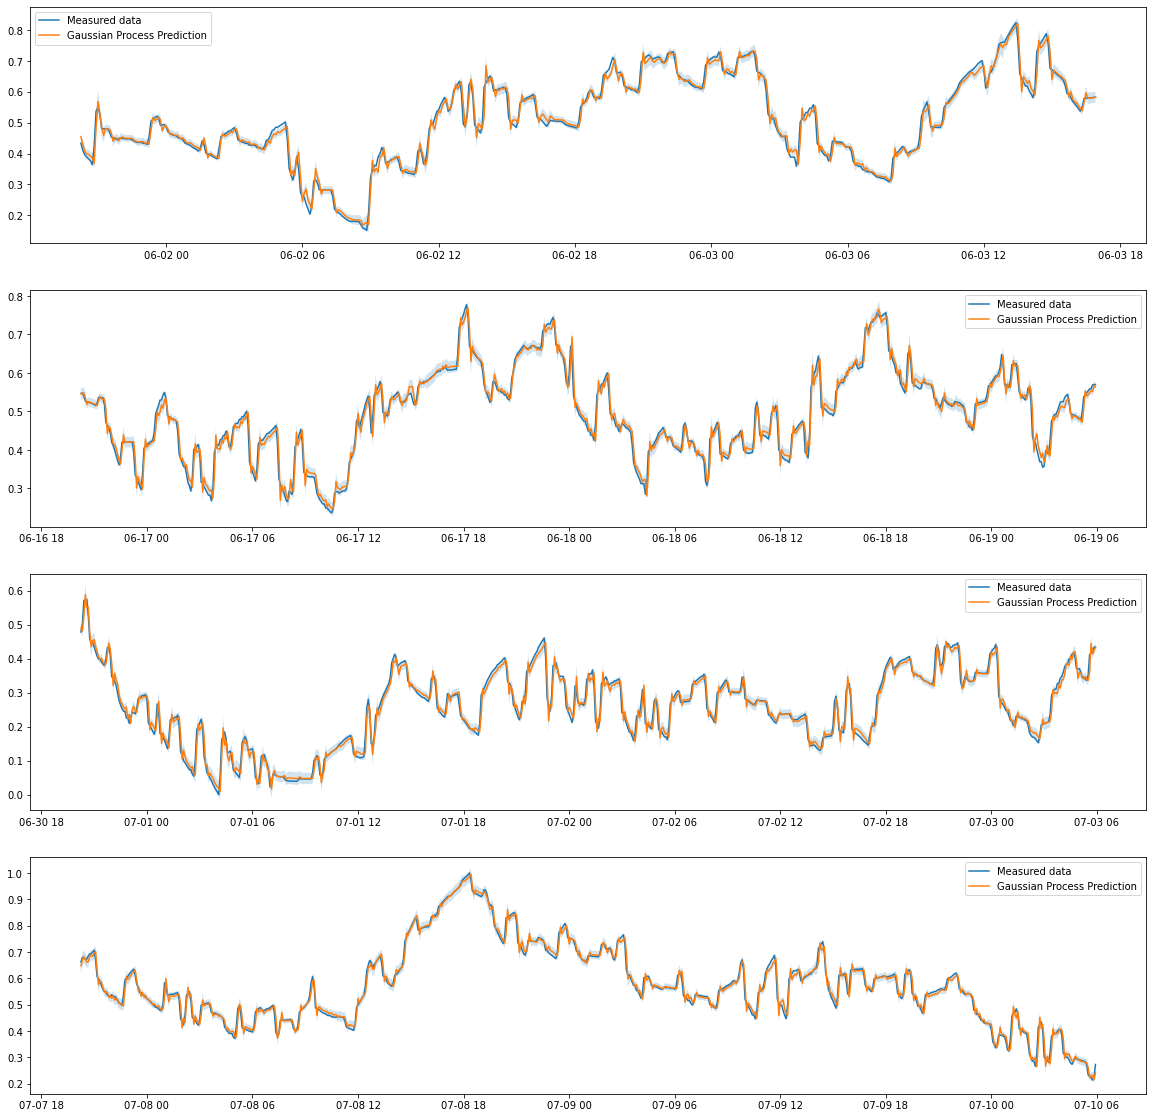

In [41]:
plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_train):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    
    plt.plot(df_iter.index, np_output_iter[:, :], label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    #plt.title(f"Model Performance on training data: {train_exps[idx]}")
    plt.legend()
plt.show()

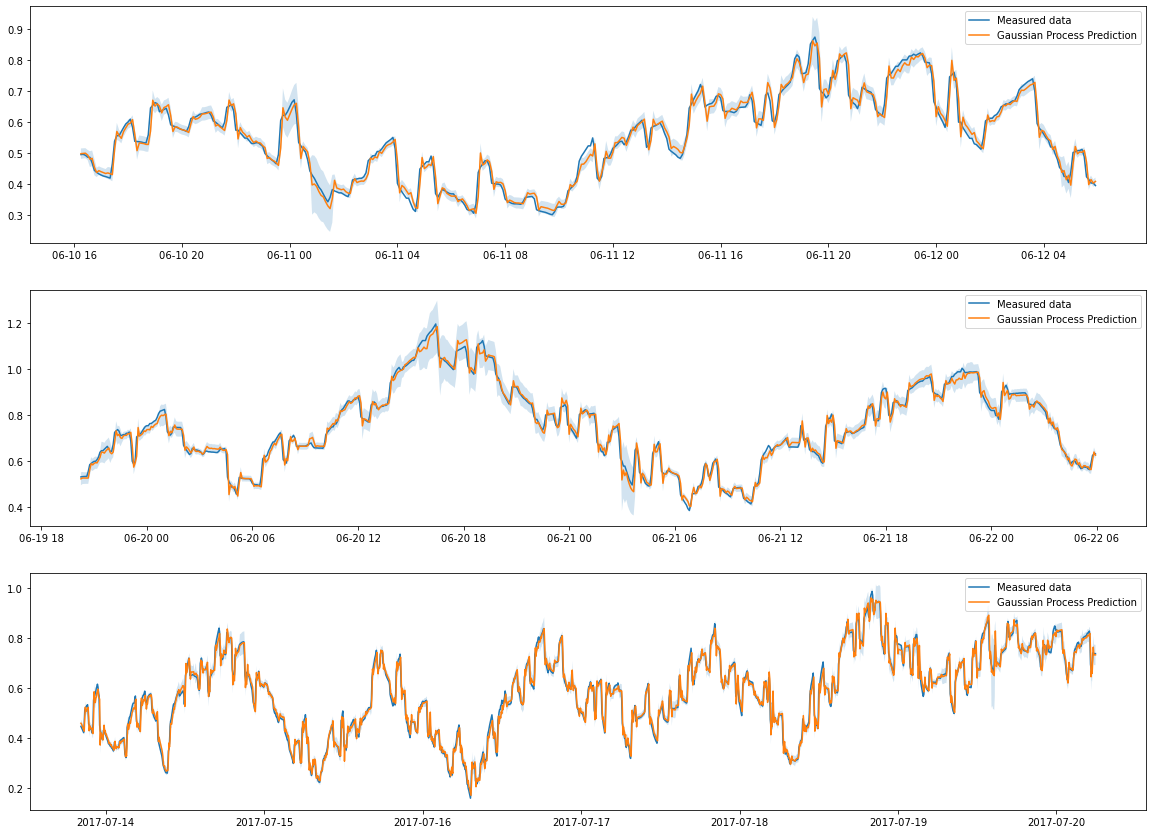

In [42]:
plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_test):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    
    plt.plot(df_iter.index, np_output_iter[:, :], label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    #plt.title(f"Model Performance on test data: {test_exps[idx]}")
    plt.legend()
plt.show()

In [43]:
np.linalg.cond(np_input_train)

219.7794477289139

In [44]:
np.linalg.cond(k(np_input_train))

1.9737396046057597e+21

In [45]:
def m_obj_value(m):

    tf_errs = 0
    tf_vars = 0
    for idx, df_iter in enumerate(dfs_gpr_test):
        df_input_iter = df_iter.drop(columns = dict_cols['y'][1] + dict_cols['u'][1])
        df_output_iter = df_iter[dict_cols['y'][1]]
        np_input_iter = df_input_iter.to_numpy()
        np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
        
        mean, var = m.predict_f(np_input_iter)

        err_iter = tf.reshape(mean - np_output_iter, (-1,))
        tf_errs += tf.tensordot(err_iter, err_iter, 1)

        var_iter = tf.reshape(var,(-1,))
        tf_vars += tf.tensordot(var_iter, var_iter, 1)

    tf_cond = np.linalg.cond(m.kernel(np_input_train))

    obj = 1 * tf_errs + 1 * tf_vars + 10 * np.log10(tf_cond)

    return obj

In [46]:
def get_gp_from_hyperparams(tf_params):

  print("Training a GP")
  rational_l = tf_params[:nb_rational_dims]
  squared_l = tf_params[nb_rational_dims:]

  k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
  k1 = gpflow.kernels.Constant(variance = variance)
  k2 = gpflow.kernels.RationalQuadratic(lengthscales = rational_l, active_dims = rational_dims, variance = variance)

  k = (k0 + k1) * k2

  m = gpflow.models.GPR(
    data = (np_input_train, np_output_train), 
    kernel = k, 
    mean_function = None
  )

  opt = gpflow.optimizers.Scipy()

  opt.minimize(m.training_loss, m.trainable_variables)

  return m

In [47]:
gpflow.utilities.parameter_dict(m)

{'.kernel.kernels[0].kernels[0].variance': <Parameter: dtype=float64, shape=[], fn="softplus", numpy=5.408436781529694>,
 '.kernel.kernels[0].kernels[0].lengthscales': <Parameter: dtype=float64, shape=[8], fn="softplus", numpy=
 array([6.94141504e+02, 5.39253193e+02, 3.14255326e+02, 2.81803398e+02,
        3.70156520e-02, 1.46936021e+01, 1.53069073e+01, 3.27369940e+02])>,
 '.kernel.kernels[0].kernels[1].variance': <Parameter: dtype=float64, shape=[], fn="softplus", numpy=86.43835724496995>,
 '.kernel.kernels[1].variance': <Parameter: dtype=float64, shape=[], fn="softplus", numpy=77.51929640071984>,
 '.kernel.kernels[1].lengthscales': <Parameter: dtype=float64, shape=[8], fn="softplus", numpy=
 array([427.42705895, 330.15913554, 258.4849923 , 217.56651871,
        414.31575845, 385.52770911, 336.59109003, 307.08417105])>,
 '.kernel.kernels[1].alpha': <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.0>,
 '.likelihood.variance': <Parameter: dtype=float64, shape=[], fn="chain_of

In [48]:
def gp_cost(tf_params):

    try:
        m = get_gp_from_hyperparams(tf_params)
        obj = m_obj_value(m)
    except tf.errors.InvalidArgumentError:
        obj = np.nan
    
    if obj == np.inf or obj > 1000:
        obj = np.nan

    return obj

In [49]:
def gp_cost_map(tf_params):
    obj = tf.map_fn(gp_cost, tf_params)
    obj = tf.reshape(obj, (-1, 1))
    return obj

In [50]:
#obj = m_obj_value(m)
#obj

In [51]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6710647087580534683]

In [52]:
search_space = trieste.space.Box([0.1]*nb_dims, [1]*nb_dims)

In [53]:
init_X = search_space.sample(10)

In [54]:
#observer = trieste.utils.objectives.mk_observer(gp_cost_map, OBJECTIVE)

#initial_data = observer(init_X)

In [55]:
#bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

In [56]:
## Optimization with failure regions

In [57]:
OBJECTIVE = "OBJECTIVE"
FAILURE = "FAILURE"

def gp_observer(x):
    try:
        y = gp_cost_map(x)
    except:
        y = np.nan
    print(y)
    mask = np.isfinite(y).reshape(-1)
    return {
        OBJECTIVE: trieste.data.Dataset(x[mask], y[mask]),
        FAILURE: trieste.data.Dataset(x, tf.cast(np.isfinite(y), tf.float64))
    }

In [58]:
initial_data = gp_observer(init_X)

Training a GP
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unindent does not match any outer indentation level (<tokenize>, line 187)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unindent does not match any outer indentation level (<tokenize>, line 187)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
Training a GP
tf.Tensor(
[[         nan]
 [         nan]
 [ 97.21004445]
 [ 97.01221739]
 [         nan]
 [         nan]
 [         nan]
 [ 93.7408702 ]
 [232.76088786]
 [         nan]], shape=(10, 1), 

In [59]:
def create_regression_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance=variance, lengthscales=[0.2]*nb_dims)
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)
    return gpr


def create_classification_model(data):
    kernel = gpflow.kernels.SquaredExponential(
        variance=100.0, lengthscales=[0.2]*nb_dims
    )
    likelihood = gpflow.likelihoods.Bernoulli()
    vgp = gpflow.models.VGP(data.astuple(), kernel, likelihood)
    gpflow.set_trainable(vgp.kernel.variance, False)
    return vgp


regression_model = create_regression_model(initial_data[OBJECTIVE])
classification_model = create_classification_model(initial_data[FAILURE])

In [60]:
class NatGradTrainedVGP(trieste.models.VariationalGaussianProcess):
    def optimize(self, dataset):
        gpflow.set_trainable(self.model.q_mu, False)
        gpflow.set_trainable(self.model.q_sqrt, False)
        variational_params = [(self.model.q_mu, self.model.q_sqrt)]
        adam_opt = tf.optimizers.Adam(1e-3)
        natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)

        for step in range(50):
            loss = self.model.training_loss
            natgrad_opt.minimize(loss, variational_params)
            adam_opt.minimize(loss, self.model.trainable_variables)

In [61]:
from typing import Dict

models: Dict[str, trieste.models.ModelSpec] = {
    OBJECTIVE: {
        "model": regression_model,
        "optimizer": gpflow.optimizers.Scipy(),
        "optimizer_args": {
            "minimize_args": {"options": dict(maxiter=100)},
        },
    },
    FAILURE: NatGradTrainedVGP(classification_model),
}

In [62]:
class ProbabilityOfValidity(trieste.acquisition.SingleModelAcquisitionBuilder):
    def prepare_acquisition_function(self, dataset, model):
        return lambda at: trieste.acquisition.lower_confidence_bound(model, 0.0, at)

ei = trieste.acquisition.ExpectedImprovement()
pov = ProbabilityOfValidity()
acq_fn = trieste.acquisition.Product(ei.using(OBJECTIVE), pov.using(FAILURE))
rule = trieste.acquisition.rule.EfficientGlobalOptimization(acq_fn)

In [63]:
nb_optimization_steps = 10

In [64]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(gp_observer, search_space)

In [65]:
result = bo.optimize(nb_optimization_steps, initial_data, models, rule)

Training a GP
tf.Tensor([[nan]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[nan]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[nan]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[93.78287553]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[nan]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[243.34803879]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[215.09037253]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[97.20999161]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[nan]], shape=(1, 1), dtype=float64)
Training a GP
tf.Tensor([[93.76406811]], shape=(1, 1), dtype=float64)
Optimization completed without errors


In [66]:
result = result.final_result.unwrap()

arg_min_idx = tf.squeeze(tf.argmin(result.datasets[OBJECTIVE].observations, axis=0))
print(f"query point: {result.datasets[OBJECTIVE].query_points[arg_min_idx, :]}")

query point: [0.34635562 0.26878551 0.76424444 0.92876329 0.61091314 0.35062807
 0.39009512 0.993673   0.14636107 0.4627374  0.86743204 0.25986113
 0.22203288 0.84095108 0.76710384 0.27424296]


In [67]:
best_params = result.datasets[OBJECTIVE].query_points[arg_min_idx, :]

In [68]:
#result_new = bo.optimize(nb_optimization_steps, result.datasets, result.models, rule)

In [69]:
#result = result_new.final_result.unwrap()

#arg_min_idx = tf.squeeze(tf.argmin(result.datasets[OBJECTIVE].observations, axis=0))
#print(f"query point: {result.datasets[OBJECTIVE].query_points[arg_min_idx, :]}")

In [70]:
"""
best_params =         [0.69451063, 0.5384062 , 0.23517986, 0.91982074, 0.59555472,
         0.66430469, 0.08747336, 0.42367986, 0.5296011 , 0.01447965,
         0.08559091]
"""

'\nbest_params =         [0.69451063, 0.5384062 , 0.23517986, 0.91982074, 0.59555472,\n         0.66430469, 0.08747336, 0.42367986, 0.5296011 , 0.01447965,\n         0.08559091]\n'

In [71]:
m_best = get_gp_from_hyperparams(best_params)

Training a GP


In [72]:
gpflow.utilities.parameter_dict(m_best)

{'.kernel.kernels[0].kernels[0].variance': <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.3254888624120493>,
 '.kernel.kernels[0].kernels[0].lengthscales': <Parameter: dtype=float64, shape=[8], fn="softplus", numpy=
 array([4.30304451e+02, 5.44920921e+02, 3.31080035e-01, 2.75602691e+02,
        2.03036921e-01, 5.77722987e-02, 4.90321613e-02, 6.27045340e-01])>,
 '.kernel.kernels[0].kernels[1].variance': <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.05084474259660333>,
 '.kernel.kernels[1].variance': <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.04798011609601921>,
 '.kernel.kernels[1].lengthscales': <Parameter: dtype=float64, shape=[8], fn="softplus", numpy=
 array([1.29065411e+02, 1.66011862e-02, 1.32043406e+02, 3.26582048e+01,
        2.67999815e+02, 3.31066276e-01, 3.88261183e+02, 8.10831550e-01])>,
 '.kernel.kernels[1].alpha': <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.0030523338500954927>,
 '.likelihood.variance': <Parameter

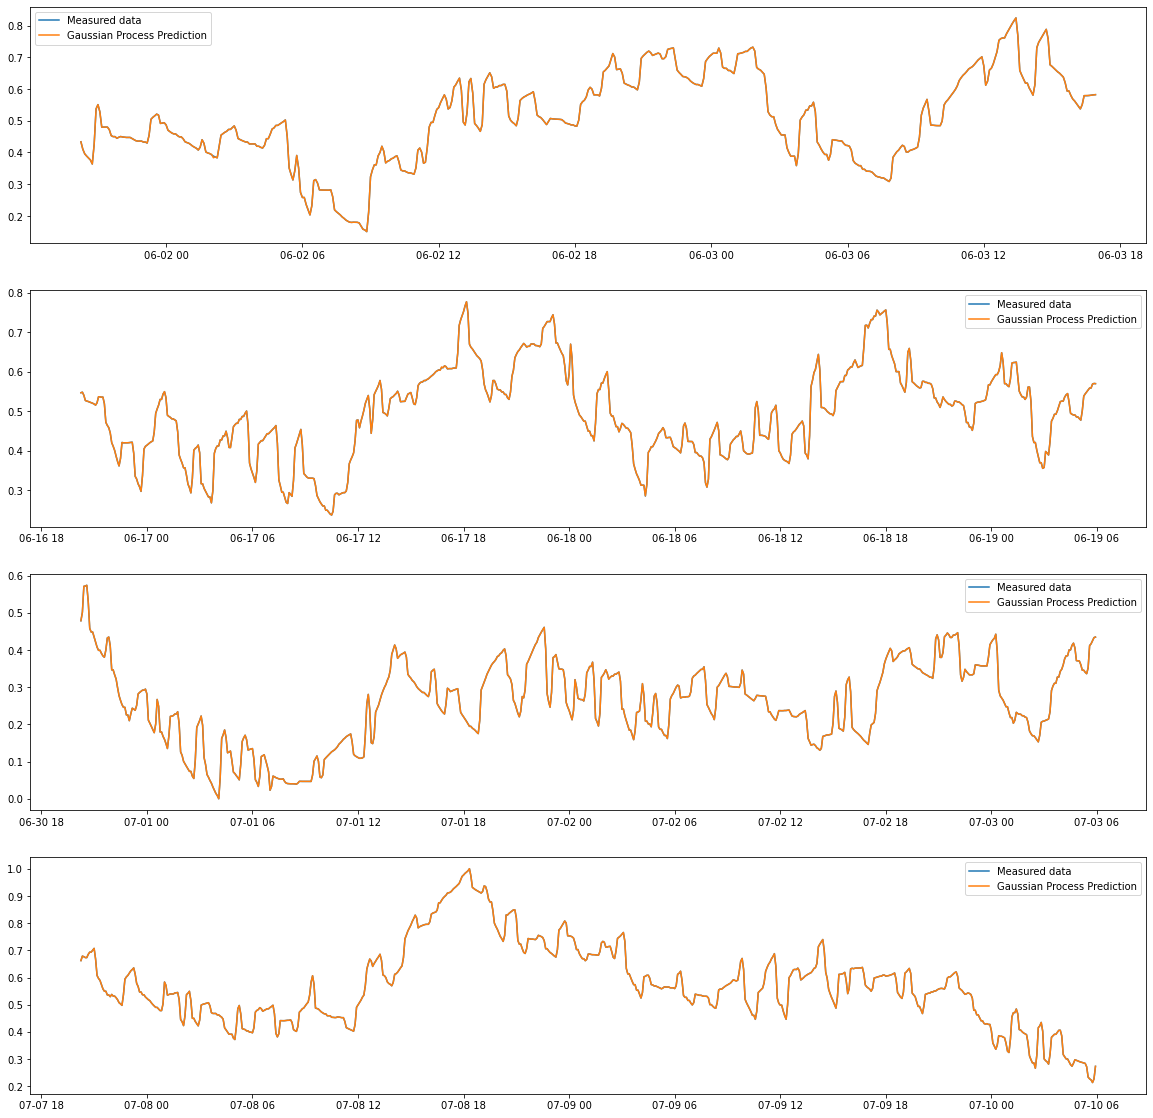

In [73]:
nb_plts = len(dfs_train)

plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_train):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m_best.predict_f(np_input_iter)
    
    plt.plot(df_iter.index, np_output_iter[:, :], label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    #plt.title(f"Model Performance on training data: {train_exps[idx]}")
    plt.legend()
plt.show()

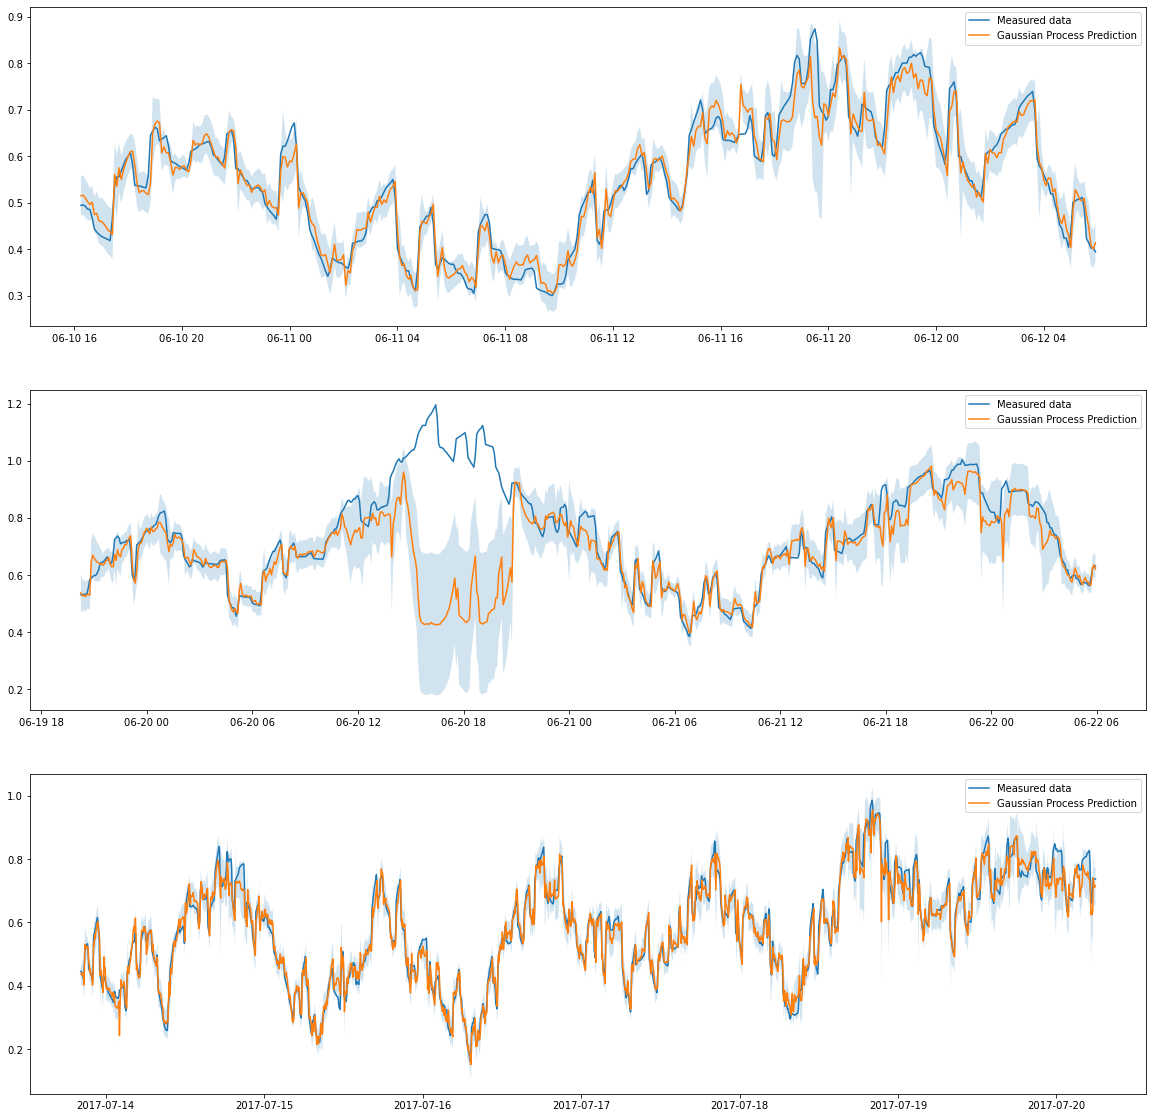

In [74]:
nb_plts = len(dfs_test)

plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_test):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m_best.predict_f(np_input_iter)
    
    plt.plot(df_iter.index, np_output_iter[:, :], label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    #plt.title(f"Model Performance on test data: {test_exps[idx]}")
    plt.legend()
plt.show()

In [75]:
np.log10(np.linalg.cond(m_best.kernel(np_input_train)))

6.816164274131061

In [76]:
m_obj_value(m_best)

<tf.Tensor: shape=(), dtype=float64, numpy=93.7408701986287>

In [77]:
df_input_train

,time_h,time_h_1,time_h_2,time_h_3,time_m,time_m_1,time_m_2,time_m_3,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat_1,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
timestamp,,,,,,,,,,,,,,,,
2017-06-01 20:15:00+02:00,0.869565,0.869565,0.869565,0.869565,0.272727,0.181818,0.090909,0.000000,0.070193,0.052175,0.529412,0.529412,0.209943,0.452997,0.461555,0.500451
2017-06-01 20:20:00+02:00,0.869565,0.869565,0.869565,0.869565,0.363636,0.272727,0.181818,0.090909,0.072266,0.070193,0.529412,0.529412,0.209943,0.433660,0.452997,0.461555
2017-06-01 20:25:00+02:00,0.869565,0.869565,0.869565,0.869565,0.454545,0.363636,0.272727,0.181818,0.061755,0.072266,0.529412,0.529412,0.047930,0.410220,0.433660,0.452997
2017-06-01 20:30:00+02:00,0.869565,0.869565,0.869565,0.869565,0.545455,0.454545,0.363636,0.272727,0.044350,0.061755,0.529412,0.529412,0.047930,0.395873,0.410220,0.433660
2017-06-01 20:35:00+02:00,0.869565,0.869565,0.869565,0.869565,0.636364,0.545455,0.454545,0.363636,0.033265,0.044350,0.529412,0.529412,0.047930,0.388866,0.395873,0.410220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-10 05:35:00+02:00,0.217391,0.217391,0.217391,0.217391,0.636364,0.545455,0.454545,0.363636,0.000000,0.000000,0.294118,0.294118,0.129560,0.233537,0.271685,0.284230
2017-07-10 05:40:00+02:00,0.217391,0.217391,0.217391,0.217391,0.727273,0.636364,0.545455,0.454545,0.000000,0.000000,0.294118,0.294118,0.129560,0.227494,0.233537,0.271685
2017-07-10 05:45:00+02:00,0.217391,0.217391,0.217391,0.217391,0.818182,0.727273,0.636364,0.545455,0.000000,0.000000,0.294118,0.294118,0.129560,0.223403,0.227494,0.233537


## Multistep prediction

In [78]:
df_input = dfs_gpr_test[0].drop(columns = dict_cols['u'][1] + dict_cols['y'][1])
df_output = dfs_gpr_test[0][dict_cols['y'][1]]

In [79]:
idx = 1
nb_predictions = 10
N_pred = 8

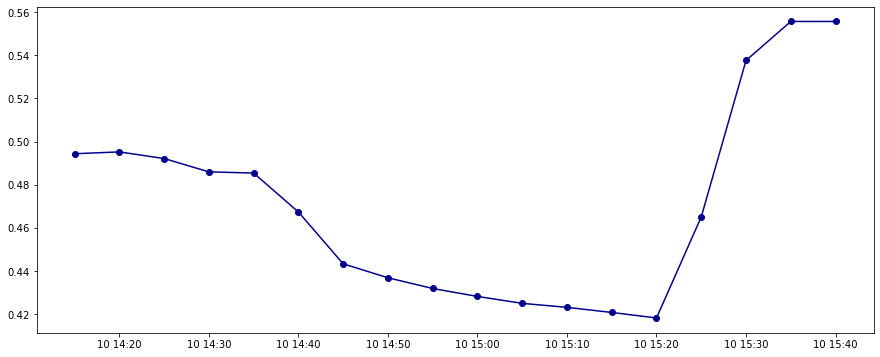

In [80]:
plt.figure()
plt.plot(df_output.iloc[:nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')

In [81]:
df_iter

,time_h,time_h_1,time_h_2,time_h_3,time_m,time_m_1,time_m_2,time_m_3,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat,SimulatedHeat_1,SimulatedTemp,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
timestamp,,,,,,,,,,,,,,,,,,
2017-07-13 20:15:00+02:00,0.869565,0.869565,0.869565,0.869565,0.272727,0.181818,0.090909,0.000000,0.155580,0.096442,0.647059,0.647059,0.124762,0.124762,0.446260,0.450121,0.454307,0.496151
2017-07-13 20:20:00+02:00,0.869565,0.869565,0.869565,0.869565,0.363636,0.272727,0.181818,0.090909,0.085568,0.155580,0.647059,0.647059,0.124762,0.124762,0.441746,0.446260,0.450121,0.454307
2017-07-13 20:25:00+02:00,0.869565,0.869565,0.869565,0.869565,0.454545,0.363636,0.272727,0.181818,0.070732,0.085568,0.647059,0.647059,0.124762,0.124762,0.436620,0.441746,0.446260,0.450121
2017-07-13 20:30:00+02:00,0.869565,0.869565,0.869565,0.869565,0.545455,0.454545,0.363636,0.272727,0.066549,0.070732,0.647059,0.647059,0.124762,0.124762,0.431479,0.436620,0.441746,0.446260
2017-07-13 20:35:00+02:00,0.869565,0.869565,0.869565,0.869565,0.636364,0.545455,0.454545,0.363636,0.067385,0.066549,0.647059,0.647059,0.124762,0.124762,0.426377,0.431479,0.436620,0.441746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-20 05:35:00+02:00,0.217391,0.217391,0.217391,0.217391,0.636364,0.545455,0.454545,0.363636,0.003098,0.002994,0.529412,0.529412,0.709465,0.709465,0.739007,0.740268,0.688490,0.661305
2017-07-20 05:40:00+02:00,0.217391,0.217391,0.217391,0.217391,0.727273,0.636364,0.545455,0.454545,0.003089,0.003098,0.529412,0.529412,0.709465,0.709465,0.737829,0.739007,0.740268,0.688490
2017-07-20 05:45:00+02:00,0.217391,0.217391,0.217391,0.217391,0.818182,0.727273,0.636364,0.545455,0.003079,0.003089,0.529412,0.529412,0.709465,0.709465,0.737296,0.737829,0.739007,0.740268


Text(0.5, 1.0, 'Prediction over 8 steps')

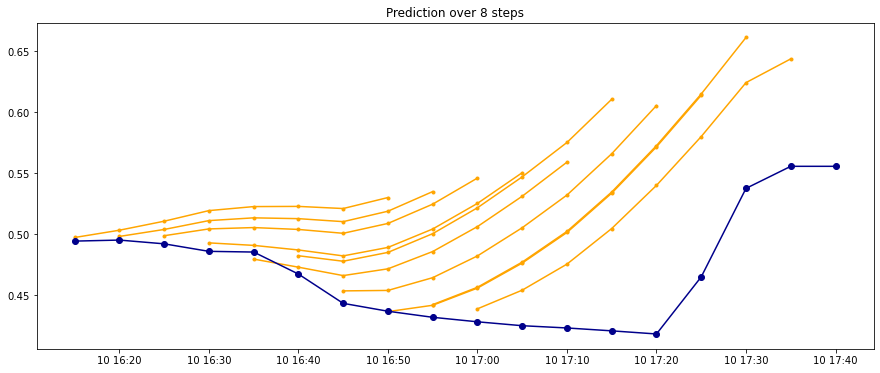

In [82]:
plt.figure()

y_name = dict_cols['y'][1][0]
for idx in range(nb_predictions):
    df_iter = df_input.iloc[idx:(idx + N_pred)].copy()
    for idxx in range(N_pred - 1):
        idx_old = df_iter.index[idxx]
        idx_new = df_iter.index[idxx+1]
        mean, var = m_best.predict_f(df_iter.loc[idx_old, :].to_numpy().reshape(1, -1))
        df_iter.loc[idx_new, f'{y_name}_1'] = mean.numpy().flatten()
        for lag in range(2, dict_cols['y'][0] + 1):
            df_iter.loc[idx_new, f"{y_name}_{lag}"] = df_iter.loc[idx_old, f"{y_name}_{lag-1}"]
        
    mean_iter, var_iter = m_best.predict_y(df_iter.to_numpy())
    plt.plot(df_iter.index, mean_iter.numpy(), '.-', label = 'predicted', color = 'orange')
plt.plot(df_output.iloc[:nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')
plt.title(f"Prediction over {N_pred} steps")